In [1]:
import anndata
import scanpy as sc
import numpy as np 
import scvi
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse

%load_ext autoreload
%autoreload 2

## load data

In [211]:
st_adata = sc.read_h5ad("Liver_normal_10um_annotated.h5ad")

In [212]:
sc_adata = sc.read_csv("GSE84498_umitab.txt.gz", delimiter="\t").T
# match genes 
matching_symbols = []
for gene_info_parse in sc_adata.var.index:
    gene_info_list = gene_info_parse.split(";")
    res = 0
    temp_matches = []
    for gene_info in gene_info_list:
        if gene_info in st_adata.var.index:
            res += 1
            temp_matches += [gene_info]
    if res == 0:
        matching_symbols += [gene_info_list[0]]
    else:
        matching_symbols += [temp_matches[0]]
        
mat = scipy.sparse.csr_matrix(sc_adata.X)
sc_adata = anndata.AnnData(mat, sc_adata.obs, pd.DataFrame(matching_symbols, index=matching_symbols, columns=["symbol"]))


In [213]:
# # change names of single-cell genes
# sc_adata.var["symbols"] = matching_symbols
# sc_adata.var.index = sc_adata.var["symbols"]

mat = scipy.sparse.csr_matrix(st_adata.X)
st_adata = anndata.AnnData(mat, st_adata.obs, st_adata.var)

In [214]:
sc_adata = sc.read_h5ad("tabula-muris-senis-liver-droplet.h5ad")

old_to_new = {"hepatocyte": "0", 
              "Kupffer cell": "1", 
              "endothelial cell of hepatic sinusoid": "2",
              "B cell":"NA", 
              "myeloid leukocyte":"NA",
              "mature NK T cell": "NA",
              "CD8-positive, alpha-beta T cell":"NA", 
              "CD4-positive, alpha-beta T cell":"NA",
              "NK cell": "NA",
              "neutrophil": "NA",
              "plasmacytoid dendritic cell": "NA",
              "hepatic stellate cell": "NA",
              "duct epithelial cell": "NA",
             }

sc_adata.obs['cell_type'] = (
    sc_adata.obs['cell_ontology_class']
    .map(old_to_new)
)
sc_adata = sc_adata[sc_adata.obs['cell_type'] != "NA"].copy()
sc_adata.X = sc_adata.raw.X

In [215]:
sc_adata.obs['cell_ontology_class'].value_counts()

hepatocyte                              2929
Kupffer cell                            2546
endothelial cell of hepatic sinusoid     675
Name: cell_ontology_class, dtype: int64

In [216]:
# get intersect
intersect_ = np.intersect1d(sc_adata.var.index, st_adata.var.index)

In [217]:
sc_adata = sc_adata[:, intersect_].copy()
st_adata = st_adata[:, intersect_].copy()

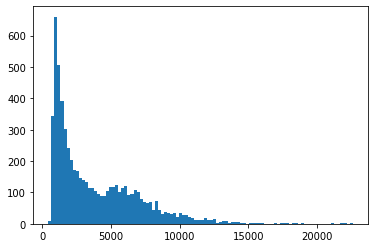

In [218]:
sc_adata.obs["n_counts"] = np.sum(sc_adata.X.A, axis=1)
plt.hist(sc_adata.obs["n_counts"], bins=100)
plt.show()

In [219]:
# sc_adata = sc_adata[sc_adata.obs["n_counts"] > 1000]

## annotate single-cell

In [220]:
sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

In [221]:
sc.tl.pca(sc_adata, n_comps=30)
sc.pp.neighbors(sc_adata, metric="cosine")
sc.tl.umap(sc_adata)

In [ ]:
# sc.tl.leiden(sc_adata, resolution=0.2, random_state=0)

# old_to_new = {"0":"0", "1":"0", "2":"0", "3":"1", "4":"2"}

# sc_adata.obs['cell_type'] = (
#     sc_adata.obs['leiden']
#     .map(old_to_new)
#     .astype('category')
# )

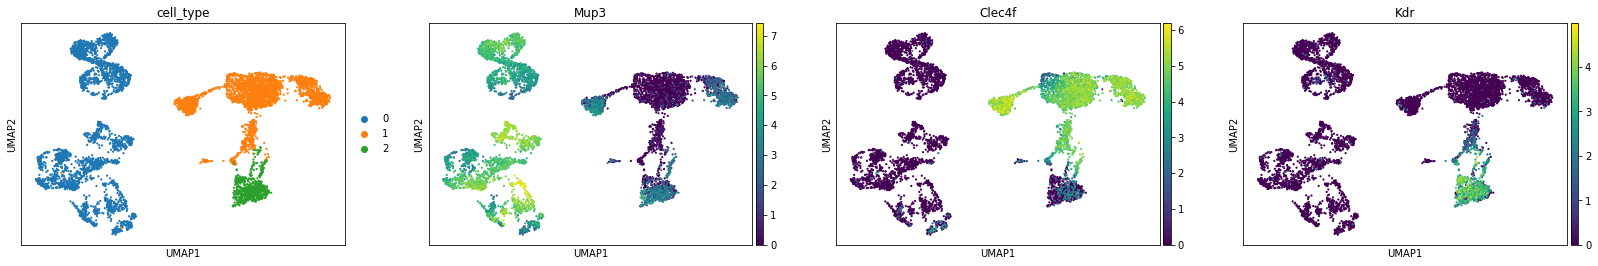

In [776]:
sc.pl.umap(sc_adata, color=["cell_type", "Mup3", "Clec4f", "Kdr"])
# 0 is hepatocytes
# 1 is Macs
# 2 is Endothelial

## observe spatial data

In [223]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [224]:
st_adata

AnnData object with n_obs × n_vars = 21041 × 2730
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'tile', 'X', 'Y', 'X_expand', 'Y_expand', 'condition', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    uns: 'log1p'
    layers: 'counts'

In [398]:
18306 + 472 + 474

19252

In [399]:
st_adata.obs["cell_type"].value_counts()
# 474 ENDO
# 472 Macs
# 7678 + 5361 + 4626 + 641 = 18306 Heptocytes
# total 18306 + 472 + 474
(18306 / 19252, 472 / 19252, 474 / 19252)

(0.9508622480781218, 0.024516933305630585, 0.024620818616247663)

# export for RCTD

In [225]:
target_list = [2, 4, 8]
key_list = ["cell_type"] + [str(target) + "th_sub-cell_type" for target in target_list]

# sc_adata.obs["cell_type"] = sc_adata.obs["leiden_"]
sc_adata.uns["key_clustering"] = key_list
sc_adata.uns["target_list"] = [1] + target_list
sc_adata.write_h5ad("sc_simu.h5ad")

st_adata.obsm["locations"] = np.vstack((st_adata.obs["X"], st_adata.obs["Y"])).T
st_adata.obs["n_counts"] = np.sum(st_adata.X.A, axis=1)
st_adata.uns["key_clustering"] = key_list
st_adata.uns["target_list"] = [1] + target_list
st_adata.write_h5ad("st_simu.h5ad")

insights we could get
1. proportions are known (80 / 10 / 10) / Pie chart ?
2. Seurat seems to miss spots
3. Check for macs closer to PV (away from Cyp2e1)
4. hepatocyte zonation
5. hepatic stellate zonation
6. endothelial zonation


# visualize slice

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


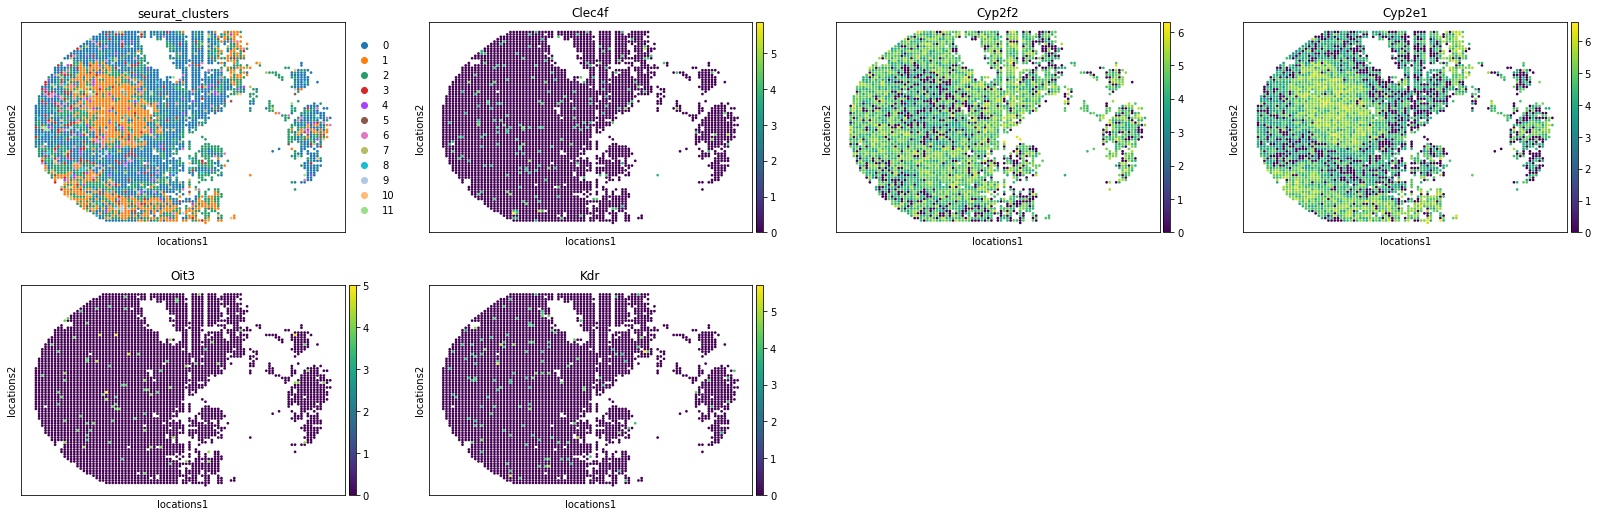

In [419]:
section = 2104
liver_section = st_adata[st_adata.obs["tile"] == section].copy()
sc.pl.embedding(liver_section, "locations", color=["seurat_clusters", "Clec4f", "Cyp2f2", "Cyp2e1", "Oit3", "Kdr"])

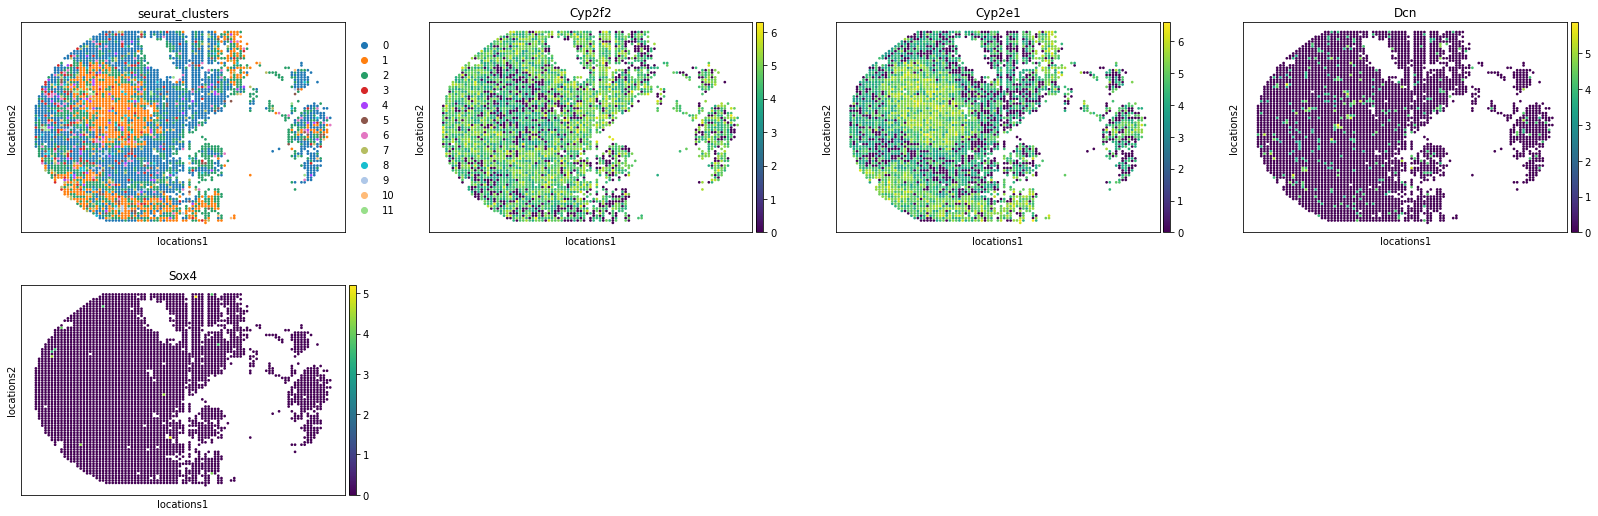

In [426]:
sc.pl.embedding(liver_section, "locations", color=["seurat_clusters", "Cyp2f2", "Cyp2e1", "Dcn", "Sox4"])

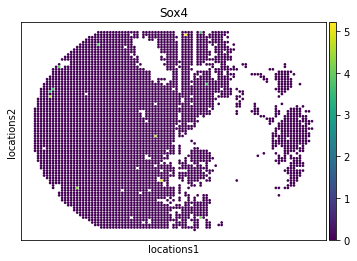

In [427]:
sc.pl.embedding(liver_section, "locations", color=["Sox4"])

## run DestVI

In [226]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="cell_type")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6150 cells, 2730 vars, 1 batches, 
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [227]:
sc_model = scvi.model.CondSCVI(sc_adata)
sc_model.train(max_epochs=500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [07:27<00:00,  1.12it/s, loss=1.52e+03, v_num=1]


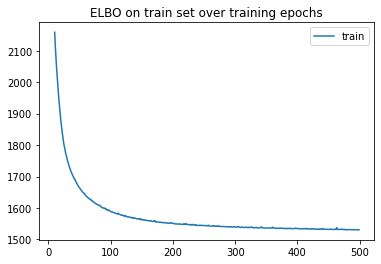

In [228]:
plt.plot(sc_model.history["elbo_train"][10:], label="train")
plt.title("ELBO on train set over training epochs")
plt.legend()

In [229]:
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 21041 cells, 2730 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [328]:
spatial_model = scvi.model.DestVI.from_rna_model(st_adata, sc_model, l1_scalar=1.5e5)
# for mars-seq:
# 1 or 10 do not do anything
# 1e4 is competitive (on mars)
# 5e4 is bad 0.88 0.930 (on tabula)
# 9e4 is bad? 0.89 0.932 (on tabula)
# 1e5 is pretty cool (on mars) good 0.921 0.956 (on tabula)
# 1.5e5 is starting to smell good 0.934 0.9607
# 2e5 is 0.902 0.933 (on tabula)
# 5e5 is 0.90 0.90 (on tabula)
# 1e6 less good (on mars)
spatial_model.train(max_epochs=250, train_size=1.)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [12:41<00:00,  3.05s/it, loss=8.5e+06, v_num=1] 


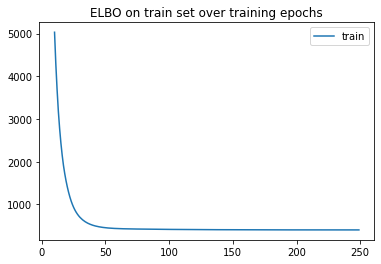

In [329]:
plt.plot(spatial_model.history["elbo_train"][10:], label="train")
plt.title("ELBO on train set over training epochs")
plt.legend()

# paper figure

Figure:
1. Show data with annotations from Seurat
2. Show proportions on data for DestVI (Hep / Endo / Macs)
3. Show marginal proportions and compare to seurat (piled bar plot)
4. Show hepatocyte zonation

In [434]:
proportions = spatial_model.get_proportions()

# 0 is hepatocytes
# 1 is Macs
# 2 is Endothelial

st_adata.obs["Hepatocytes"] = proportions["0"]
st_adata.obs["Macs"] = proportions["1"]
st_adata.obs["Endothelial"] = proportions["2"]

In [513]:
# This yielded 27 central (Akr1c6, Alad, Blvrb, C6, Car3, Ccdc107, Cml2, Cyp2c68, Cyp2d9, Cyp3a11, Entpd5, Fmo1, Gsta3, Gstm1, Gstm6, Gstt1, Hpd, Hsd17b10, Inmt, Iqgap2, Mgst1, Nrn1, Pex11a, Pon1, Psmd4, Slc22a1, Tex264) and 
# manually added Cyp2e1
# 28 portal (Afm, Aldh1l1, Asl, Ass1, Atp5a1, Atp5g1, C8a, C8b, Ces3b, Cyp2f2, Elovl2, Fads1, Fbp1, Ftcd, Gm2a, Hpx, Hsd17b13, Ifitm3, Igf1, Igfals, Khk, Mug2, Pygl, Sepp1, Serpina1c, Serpina1e, Serpind1, Vtn) landmark genes. 

central_string = "Cyp2e1, Akr1c6, Alad, Blvrb, C6, Car3, Ccdc107, Cml2, Cyp2c68, Cyp2d9, Cyp3a11, Entpd5, Fmo1, Gsta3, Gstm1, Gstm6, Gstt1, Hpd, Hsd17b10, Inmt, Iqgap2, Mgst1, Nrn1, Pex11a, Pon1, Psmd4, Slc22a1, Tex264"
portal_string = "Afm, Aldh1l1, Asl, Ass1, Atp5a1, Atp5g1, C8a, C8b, Ces3b, Cyp2f2, Elovl2, Fads1, Fbp1, Ftcd, Gm2a, Hpx, Hsd17b13, Ifitm3, Igf1, Igfals, Khk, Mug2, Pygl, Sepp1, Serpina1c, Serpina1e, Serpind1, Vtn"

central_list = np.intersect1d(liver_section.var.index, central_string.split(", "))
print(f"Central genes: {central_list}")

portal_list = np.intersect1d(liver_section.var.index, portal_string.split(", "))
portal_list = ["Cyp2f2", "Hpx", "Hsd17b13", "Mug2", "Serpina1e"]
print(f"Portal genes: {portal_list}")

score = st_adata[:, central_list].X.sum(1).A - st_adata[:, portal_list].X.sum(1).A
st_adata.obs["zone"] = (score - score.mean()) / score.std()

Central genes: ['Akr1c6' 'Car3' 'Cyp2d9' 'Cyp2e1' 'Cyp3a11' 'Gsta3' 'Gstm1' 'Inmt'
 'Mgst1' 'Nrn1' 'Pex11a' 'Pon1' 'Slc22a1']
Portal genes: ['Cyp2f2', 'Hpx', 'Hsd17b13', 'Mug2', 'Serpina1e']


In [634]:
imputed_values = spatial_model.get_scale_for_ct("0")

In [636]:
st_adata.obs["imp_central"] = imputed_values["Cyp2e1"]
st_adata.obs["imp_portal"] = imputed_values["Cyp2f2"]
st_adata.obs["imp_central"] = np.log(1 + 1e5 * imputed_values[central_list].sum(1)/ np.sum(imputed_values.values, 1))
st_adata.obs["imp_portal"] = np.log(1 + 1e5 * imputed_values[portal_list].sum(1) / np.sum(imputed_values.values, 1))

In [637]:
# 2106 has many macrophages
# 2104 is good for hepatocytes zonation
# section = 2106

section = 2104
liver_section = st_adata[st_adata.obs["tile"] == section].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [715]:
prop_destvi = np.array([st_adata.obs["Hepatocytes"].mean(), st_adata.obs["Macs"].mean(), st_adata.obs["Endothelial"].mean()])
prop_seurat = np.array((18306 / 19252, 472 / 19252, 474 / 19252))
prop = np.vstack((prop_destvi, prop_seurat))

In [775]:
prop

array([[0.70934772, 0.1348035 , 0.15584876],
       [0.95086225, 0.02451693, 0.02462082]])

472 1064 190 1346


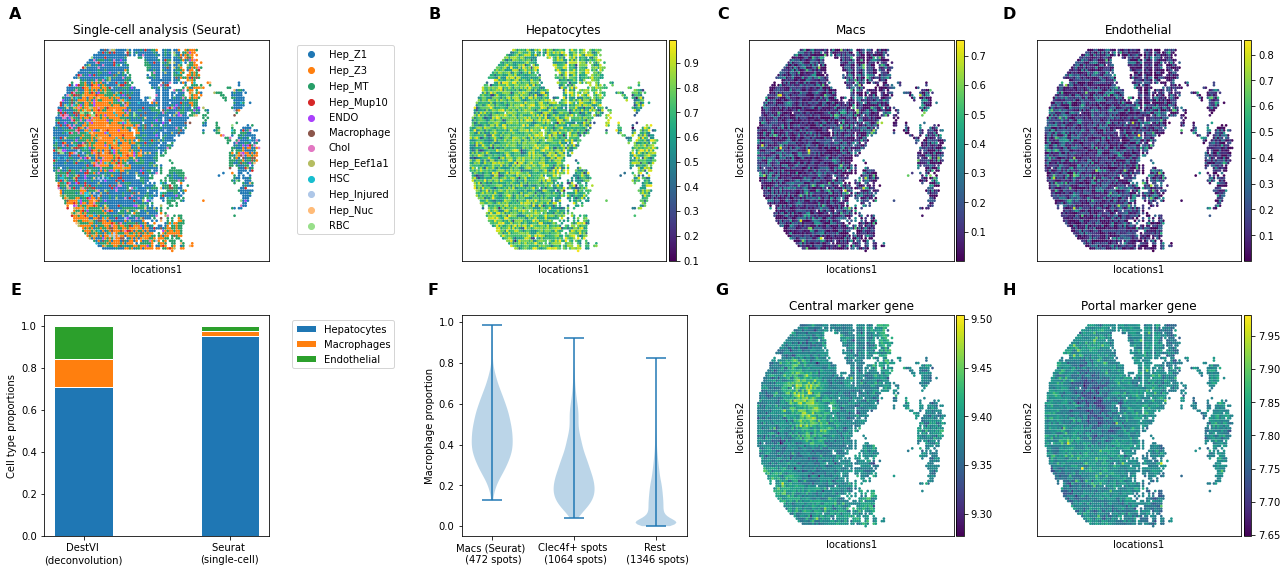

In [774]:
gs_kw = dict(width_ratios=[1, 0.3, 1, 1, 1], height_ratios=[1, 1])
fig, axes = plt.subplots(2, 5, figsize=(18, 8),gridspec_kw=gs_kw)
sc.pl.embedding(liver_section, "locations", color="cell_type", ax=axes[0, 0], show=False)
axes[0, 0].set_title("Single-cell analysis (Seurat)")
sc.pl.embedding(liver_section, "locations", color="Hepatocytes", ax=axes[0, 2], show=False)
sc.pl.embedding(liver_section, "locations", color="Macs", ax=axes[0, 3], show=False)
sc.pl.embedding(liver_section, "locations", color="Endothelial", ax=axes[0, 4], show=False)

legend = axes[0, 0].legend()
axes[0, 1].legend(legend.legendHandles,[x.get_text() for x in legend.texts])
legend.remove()
axes[0, 1].axis("off")

axes[0, 0].text(-0.1, 1.15, "A", transform=axes[0, 0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axes[0, 2].text(-0.1, 1.15, "B", transform=axes[0, 2].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axes[0, 3].text(-0.1, 1.15, "C", transform=axes[0, 3].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axes[0, 4].text(-0.1, 1.15, "D", transform=axes[0, 4].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

r = [0, 1]
bar1 = axes[1, 0].bar(r, prop[:, 0], edgecolor='white', width=0.4, label="Hepatocytes")
axes[1, 0].bar(r, prop[:, 1], bottom=prop[:, 0], edgecolor='white', width=0.4, label="Macrophages")
axes[1, 0].bar(r, prop[:, 2], bottom=[i+j for i,j in zip(prop[:, 1], prop[:, 0])], 
        edgecolor='white', width=0.4, label="Endothelial")
axes[1, 0].set_xticks(r)
axes[1, 0].set_xticklabels(["DestVI \n(deconvolution)", "Seurat \n(single-cell)"])
axes[1, 0].legend()
axes[1, 0].set_ylabel("Cell type proportions")
legend = axes[1, 0].legend()
axes[1, 1].legend(legend.legendHandles,[x.get_text() for x in legend.texts])
legend.remove()
axes[1, 1].axis("off")
 
mask = st_adata.obs["cell_type"] == "Macrophage" 
mask_2 = st_adata.raw.X[:, np.where(st_adata.var.index == "Clec4f")[0]].A[:, 0] > 0
print(sum(mask), sum(mask_2), sum(mask & mask_2), sum(mask | mask_2))
axes[1, 2].violinplot([st_adata.obs["Macs"][mask], st_adata.obs["Macs"][mask_2], st_adata.obs["Macs"][~(mask | mask_2)]])
axes[1, 2].set_xticks([1, 2, 3])
axes[1, 2].set_xticklabels(["Macs (Seurat) \n (472 spots)", "Clec4f+ spots \n (1064 spots)", "Rest \n (1346 spots)"])
axes[1, 2].set_ylabel("Macrophage proportion")

sc.pl.embedding(liver_section, "locations", color="imp_central", ax=axes[1, 3], show=False)
axes[1, 3].set_title("Central marker gene")
sc.pl.embedding(liver_section, "locations", color="imp_portal", ax=axes[1, 4], show=False)
axes[1, 4].set_title("Portal marker gene")

axes[1, 0].text(-0.1, 1.15, "E", transform=axes[1, 0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axes[1, 2].text(-0.1, 1.15, "F", transform=axes[1, 2].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axes[1, 3].text(-0.1, 1.15, "G", transform=axes[1, 3].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axes[1, 4].text(-0.1, 1.15, "H", transform=axes[1, 4].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

472 1064 190 1346


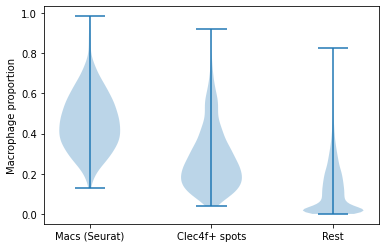

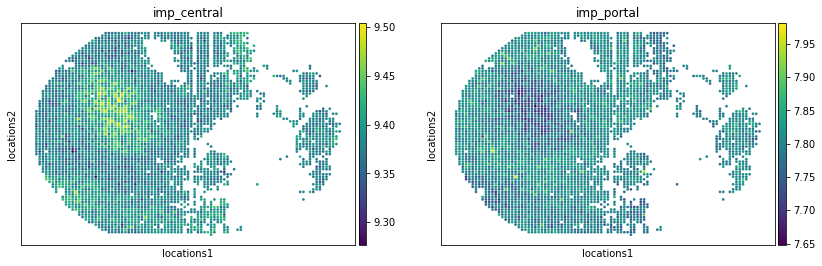

In [702]:
# not convinced by this below, the data probably isn't good enough...
from scipy import stats
zscore_portal = stats.zscore(liver_section.obs["imp_central"])
liver_section.obs["zimp_portal"] = zscore_portal

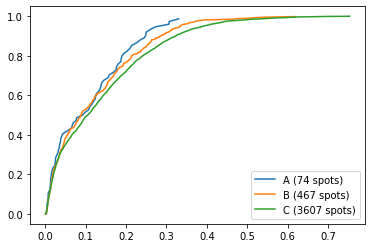

In [703]:
def make_mask(array, top=5, bottom=-5):
    return (array.values >= bottom) & (array.values <= top)

vals = liver_section.obs["zimp_portal"].values.copy().astype(np.str)

mask = make_mask(liver_section.obs["zimp_portal"], bottom=-5, top=-2)
x = np.sort(liver_section.obs["Macs"][mask])
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label=f"A ({mask.sum()} spots)")
vals[mask] = "A"

mask = make_mask(liver_section.obs["zimp_portal"], bottom=-2, top=-1)
x = np.sort(liver_section.obs["Macs"][mask])
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label=f"B ({mask.sum()} spots)")
vals[mask] = "B"

mask = make_mask(liver_section.obs["zimp_portal"], bottom=-1, top=6)
x = np.sort(liver_section.obs["Macs"][mask])
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label=f"C ({mask.sum()} spots)")
vals[mask] = "C"

# mask = make_mask(liver_section.obs["zimp_portal"], bottom=0, top=6)
# x = np.sort(liver_section.obs["Macs"][mask])
# y = np.arange(len(x))/float(len(x))
# plt.plot(x, y, label=f"D ({mask.sum()} spots)")
# vals[mask] = "D"
plt.legend()
plt.show()

... storing 'region' as categorical


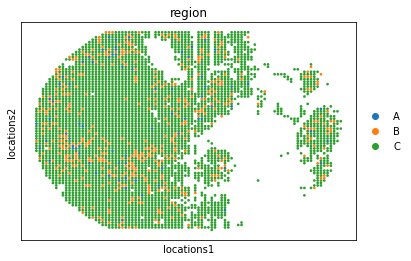

In [704]:
liver_section.obs["region"] = vals
sc.pl.embedding(liver_section, "locations", color=["region"])

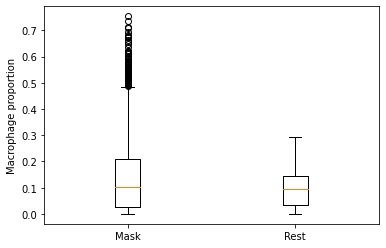

In [590]:
mask = liver_section.obs["imp_portal"]>2.55
plt.boxplot([liver_section.obs["Macs"][mask], liver_section.obs["Macs"][~mask]])
plt.xticks(ticks=[1, 2], labels=["Mask", "Rest"])
plt.ylabel("Macrophage proportion")
plt.show()

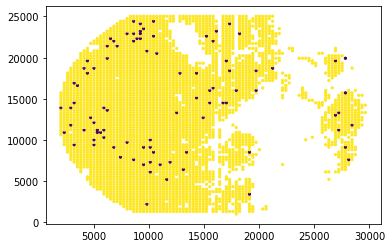

In [581]:
plt.scatter(liver_section.obsm["locations"][:, 0], liver_section.obsm["locations"][:, 1], s=5, c=liver_section.obs["imp_central"]>4.1)

## Investigate the results, hepatocytes zonation and localization of rare cell types

474 729 132 1071


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


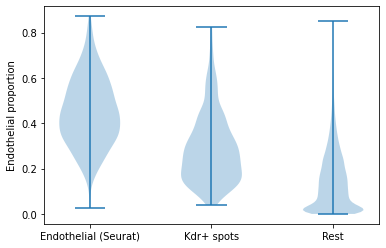

In [483]:
mask = st_adata.obs["cell_type"] == "ENDO" 
mask_2 = st_adata.raw.X[:, np.where(st_adata.var.index == "Kdr")[0]].A[:, 0] > 0
print(sum(mask), sum(mask_2), sum(mask * mask_2), sum(mask | mask_2))
plt.violinplot([st_adata.obs["Endothelial"][mask], st_adata.obs["Endothelial"][mask_2], st_adata.obs["Endothelial"][~(mask | mask_2)]])
plt.xticks(ticks=[1, 2, 3], labels=["Endothelial (Seurat)", "Kdr+ spots", "Rest"])
plt.ylabel("Endothelial proportion")
plt.show()

In [388]:
# 2106 for macrophages
# 2104 for hepatocytes zonation
# section = 2106

section = 2104
liver_section = st_adata[st_adata.obs["tile"] == section].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


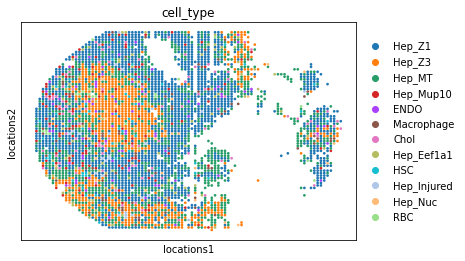

In [389]:
sc.pl.embedding(liver_section, "locations", color="cell_type")

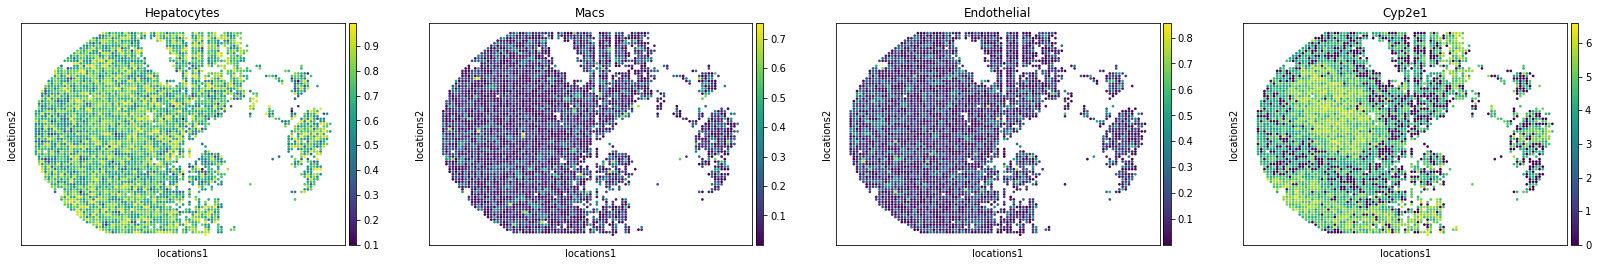

In [421]:
sc.pl.embedding(liver_section, "locations", color=["Hepatocytes", "Macs", "Endothelial", "Cyp2e1"])

# run and explore RCTD

In [ ]:
# Rscript --vanilla /home/ubuntu/destVI-paper-code/simulations/run_RCTD.R /home/ubuntu/destVI-paper-code/scope-seq-liver /RCTD0/ 0

In [254]:
input_dir = "/home/ubuntu/destVI-paper-code/scope-seq-liver"

model_subdir = "/RCTD"+str(0)+"/"
prop = pd.read_csv(input_dir+model_subdir + '/output_weights.csv', index_col=0)
st_adata.obsm["RCTD_proportions"] = prop

In [255]:
st_adata.obs["Hepatocytes_R"] = st_adata.obsm["RCTD_proportions"]["0"]
st_adata.obs["Macs_R"] = st_adata.obsm["RCTD_proportions"]["1"]
st_adata.obs["Endothelial_R"] = st_adata.obsm["RCTD_proportions"]["2"]

474 458 67 865


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


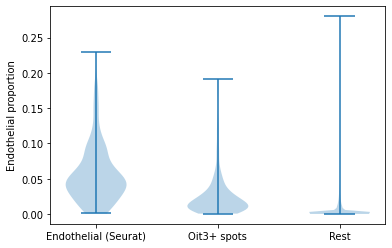

In [392]:
mask = st_adata.obs["cell_type"] == "ENDO" 
mask_2 = st_adata.raw.X[:, np.where(st_adata.var.index == "Oit3")[0]].A[:, 0] > 0
print(sum(mask), sum(mask_2), sum(mask * mask_2), sum(mask | mask_2))
plt.violinplot([st_adata.obs["Endothelial_R"][mask], st_adata.obs["Endothelial_R"][mask_2], st_adata.obs["Endothelial_R"][~(mask | mask_2)]])
plt.xticks(ticks=[1, 2, 3], labels=["Endothelial (Seurat)", "Oit3+ spots", "Rest"])
plt.ylabel("Endothelial proportion")
plt.show()

472 1064 190 1346


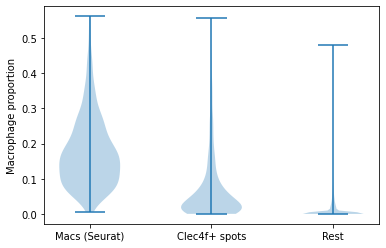

In [393]:
mask = st_adata.obs["cell_type"] == "Macrophage" 
mask_2 = st_adata.raw.X[:, np.where(st_adata.var.index == "Clec4f")[0]].A[:, 0] > 0
print(sum(mask), sum(mask_2), sum(mask & mask_2), sum(mask | mask_2))
plt.violinplot([st_adata.obs["Macs_R"][mask], st_adata.obs["Macs_R"][mask_2], st_adata.obs["Macs_R"][~(mask | mask_2)]])
plt.xticks(ticks=[1, 2, 3], labels=["Macs (Seurat)", "Clec4f+ spots", "Rest"])
plt.ylabel("Macrophage proportion")
plt.show()

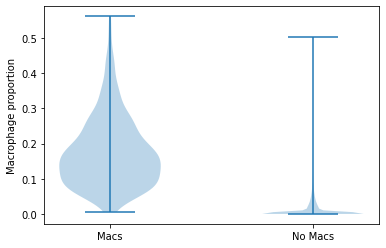

In [256]:
mask = st_adata.obs["cell_type"] == "Macrophage" 
plt.violinplot([st_adata.obs["Macs_R"][mask], st_adata.obs["Macs_R"][~mask]])
plt.xticks(ticks=[1, 2], labels=["Macs", "No Macs"])
plt.ylabel("Macrophage proportion")
plt.show()

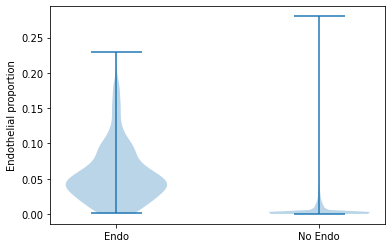

In [257]:
mask = st_adata.obs["cell_type"] == "ENDO" 
plt.violinplot([st_adata.obs["Endothelial_R"][mask], st_adata.obs["Endothelial_R"][~mask]])
plt.xticks(ticks=[1, 2], labels=["Endo", "No Endo"])
plt.ylabel("Endothelial proportion")
plt.show()

In [258]:
from sklearn.metrics import auc, roc_auc_score, log_loss, average_precision_score

In [383]:
mask_endo = st_adata.obs["cell_type"] == "ENDO"
mask_endo = mask_endo | st_adata.raw.X[:, np.where(st_adata.var.index == "Oit3")[0]].A[:, 0] > 0
mask_macs = st_adata.obs["cell_type"] == "Macrophage"
mask_macs = mask_macs | st_adata.raw.X[:, np.where(st_adata.var.index == "Clec4f")[0]].A[:, 0] > 0

print(roc_auc_score(mask_endo, st_adata.obs["Endothelial_R"]), roc_auc_score(mask_macs, st_adata.obs["Macs_R"]))
print(average_precision_score(mask_endo, st_adata.obs["Endothelial_R"]), average_precision_score(mask_macs, st_adata.obs["Macs_R"]))

0.9102202926386527 0.8586879707515843
0.39834206014565615 0.44665968922345467


In [384]:
print(roc_auc_score(mask_endo, st_adata.obs["Endothelial"]), roc_auc_score(mask_macs, st_adata.obs["Macs"]))
print(average_precision_score(mask_endo, st_adata.obs["Endothelial"]), average_precision_score(mask_macs, st_adata.obs["Macs"]))

0.8455438098490509 0.8342438570065717
0.24850145907884352 0.32096014692450797


## Below is a single-cell analysis of the raw spatial data

In [197]:
# adata.layers["counts"] = adata.X.copy()

# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=1000,
#     subset=True, # to automatically subset to the 4000 genes
#     layer="counts",
#     flavor="seurat_v3"
# )

# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
adata.raw = adata

In [201]:
sc.tl.pca(adata, n_comps=30)
sc.pp.neighbors(adata, metric="cosine")
sc.tl.umap(adata)

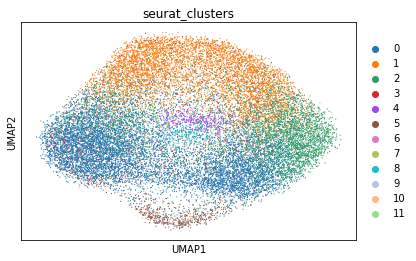

In [202]:
sc.pl.umap(adata, color="seurat_clusters")

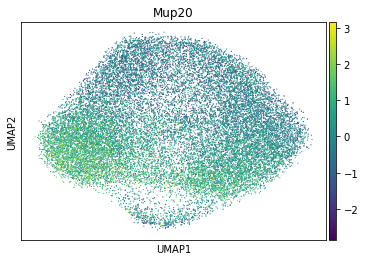

In [203]:
sc.pl.umap(adata, color="Mup20")

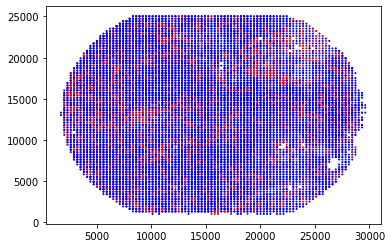

In [18]:
plt.scatter(liver_10.obs["X"], liver_10.obs["Y"], 
            c=liver_10.obs["seurat_clusters"] == "2", s=1, cmap="bwr")

In [175]:
scvi.data.setup_anndata(adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Successfully registered anndata object containing 21041 cells, 3000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [176]:
sc_model = scvi.model.SCVI(adata, n_latent=20)
sc_model.train(max_epochs=150)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [05:06<00:00,  2.04s/it, loss=414, v_num=1]


In [177]:
adata.obsm["X_scVI"] = sc_model.get_latent_representation(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_scVI")
sc.tl.umap(adata,)

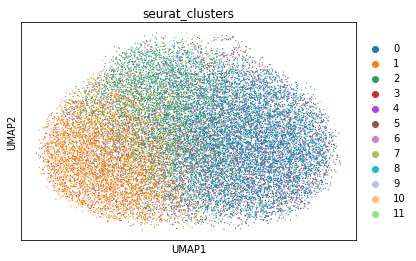

In [178]:
sc.pl.umap(adata, color="seurat_clusters")

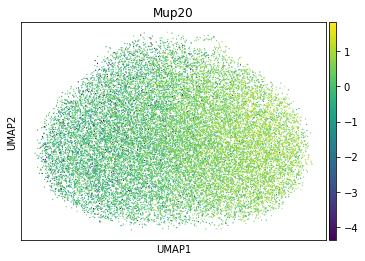

In [179]:
sc.pl.umap(adata, color="Mup20")

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


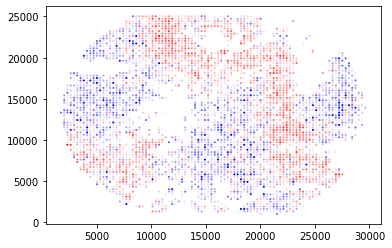

In [62]:
liver_1003 = liver_10[liver_10.obs["tile"] == 2103].copy()
plt.scatter(liver_1003.obs["X"], liver_1003.obs["Y"], 
            c=np.log(1 + liver_1003.X[:, np.where(liver_1003.var.index =="Mup20")[0][0]].A), s=1, cmap="bwr")

In [20]:
liver_10.obs["tile"].value_counts()

2103    4600
2104    4148
2105    3685
2107    3429
2102    2708
2106    2471
Name: tile, dtype: int64

In [21]:
liver_10.obs["seurat_clusters"].value_counts()

0     7678
1     5361
2     4626
3      641
4      474
5      472
6      470
7      459
8      317
9      208
10     186
11     149
Name: seurat_clusters, dtype: int64